# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [5]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [195]:
 # define your regions here
presel = {
        "mu": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt250": "( ( fj_pt>250) )",   
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",
            "MET>20": "met_pt>20",
        },
        "ele": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt250": "( ( fj_pt>250) )", 
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",  
            "MET>20": "met_pt>20",
        },
}

from make_stacked_hists_tagger import make_events_dict
channels = ["ele", "mu"]
# channels = ["ele"]
samples = [
    "ggF", 
    "VBF",  
    "WH",
    "ZH",    
    "ttH",
    "QCD",
    "WJetsLNu",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",    
    "Data",
    "WZQQorDYJets"
]

samples_dir = {
    "2016":    "../eos/Feb9_2016",
    "2016APV": "../eos/Feb9_2016APV",
    "2017":    "../eos/Feb9_2017",
    "2018":    "../eos/Feb9_2018",    
}

years = ["2017", "2016", "2016APV", "2018"]
# years = ["2018"]

In [196]:
events_dict = {}

In [208]:
taggers = [
    "v2_nor2",
#     "v35_1_1",
#     "v35_1_2",
#     "v35_2_1",
#     "v35_2_4",
#     "v35_2_5",
    "v35_2_6",
#     "v35_3_1",
#     "v35_3_2",
#     "v35_3_3",    
#     "v35_4_1",
#     "v35_4_2",
#     "v35_4_3",    

    "v35_5_4",
    
#     "v35_6_1",
#     "v35_6_2",
#     "v35_6_3",
#     "v35_6_4",
#     "v35_6_5",
    
    "v35_7_1",
    "v35_7_2",
    "v35_7_3", 
    
    "v35_8_1",
    "v35_8_2",
    "v35_8_3",     
]


for year in years:
    out = make_events_dict([year], channels, samples_dir[year], samples, presel, taggers)
    events_dict = {**events_dict, **out}

INFO:root:Finding VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1663 events
INFO:root:Applying lep_fj_dr08 selection on 1663 events
INFO:root:Applying fj_pt250 selection on 1663 events
INFO:root:Applying dphi<1.57 selection on 1663 events
INFO:root:Applying tagger>0.5 selection on 1663 events
INFO:root:Applying MET>20 selection on 1056 events
INFO:root:Will fill the VBF dataframe with the remaining 1056 events
INFO:root:tot event weight 8.986915818511086 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 69 events
INFO:root:Applying lep_fj_dr08 selection on 69 events
INFO:root:Applying fj_pt250 selection on 69 events
INFO:root:Applying dphi<1.57 selection on 69 events
INFO:root:Applying tagger>0.5 selection on 69 events
IN

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 111882 events
INFO:root:Applying lep_fj_dr08 selection on 111882 events
INFO:root:Applying fj_pt250 selection on 111882 events
INFO:root:Applying dphi<1.57 selection on 111882 events
INFO:root:Applying tagger>0.5 selection on 111882 events
INFO:root:Applying MET>20 selection on 23240 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 23240 events
INFO:root:tot event weight 1254.6445963586352 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 355362 events
INFO:root:Applying lep_fj_dr08 selection on 355362 events
INFO:root:Applying fj_pt250 selection on 355362 events
INFO:root:Applying dphi<1.57 selection on 355362 events
INFO:root:Applying tagger>0.5 selection on 355362 events
INFO:root:Applying MET>20 selection on 27390 events
INFO:root:Will fill the TT

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4611 events
INFO:root:Applying lep_fj_dr08 selection on 4611 events
INFO:root:Applying fj_pt250 selection on 4611 events
INFO:root:Applying dphi<1.57 selection on 4611 events
INFO:root:Applying tagger>0.5 selection on 4611 events
INFO:root:Applying MET>20 selection on 2818 events
INFO:root:Will fill the WH dataframe with the remaining 2818 events
INFO:root:tot event weight 3.0639648039780765 

INFO:root:Finding SingleElectron_Run2017C samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 23575 events
INFO:root:Applying lep_fj_dr08 selection on 23575 events
INFO:root:Applying fj_pt250 selection on 23575 events
INFO:root:Applying dphi<1.57 selection on 23575 events
INFO:root:Applying tagger>0.5 selection on 23575 events
INFO:root:Applying MET>20 selection on 3567 events
INFO:root:Will fill the Data dataframe with the remaining 3567 events
INFO:root:tot event wei

INFO:root:tot event weight 0.6034503172086644 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 70 events
INFO:root:Applying lep_fj_dr08 selection on 70 events
INFO:root:Applying fj_pt250 selection on 70 events
INFO:root:Applying dphi<1.57 selection on 70 events
INFO:root:Applying tagger>0.5 selection on 70 events
INFO:root:Applying MET>20 selection on 5 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 5 events
INFO:root:tot event weight 2.528760533777852 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 199 events
INFO:root:Applying lep_fj_dr08 selection on 199 events
INFO:root:Applying fj_pt250 selection on 199 events
INFO:root:Applying dphi<1.57 selection on 199 events
INFO:root:Applying tagger>0.5 selection on 19

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 475 events
INFO:root:Applying lep_fj_dr08 selection on 475 events
INFO:root:Applying fj_pt250 selection on 475 events
INFO:root:Applying dphi<1.57 selection on 475 events
INFO:root:Applying tagger>0.5 selection on 475 events
INFO:root:Applying MET>20 selection on 68 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 68 events
INFO:root:tot event weight 5.307326050567182 

INFO:root:Finding SingleElectron_Run2017F samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 31134 events
INFO:root:Applying lep_fj_dr08 selection on 31134 events
INFO:root:Applying fj_pt250 selection on 31134 events
INFO:root:Applying dphi<1.57 selection on 31134 events
INFO:root:Applying tagger>0.5 selection on 31134 events
INFO:root:Applying MET>20 selection on 4814 events
INFO:root:Will fill the Data dataframe with the remaining 4814 events
INFO:root:tot event wei

INFO:root:Applying lep_fj_dr003 selection on 5270 events
INFO:root:Applying lep_fj_dr08 selection on 5270 events
INFO:root:Applying fj_pt250 selection on 5270 events
INFO:root:Applying dphi<1.57 selection on 5270 events
INFO:root:Applying tagger>0.5 selection on 5270 events
INFO:root:Applying MET>20 selection on 3653 events
INFO:root:Will fill the WH dataframe with the remaining 3653 events
INFO:root:tot event weight 2.4769612479104888 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu


Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 148852 events
INFO:root:Applying lep_fj_dr08 selection on 148852 events
INFO:root:Applying fj_pt250 selection on 148852 events
INFO:root:Applying dphi<1.57 selection on 148852 events
INFO:root:Applying tagger>0.5 selection on 148852 events
INFO:root:Applying MET>20 selection on 36873 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 36873 events
INFO:root:tot event weight 2012.4104307155308 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 375217 events
INFO:root:Applying lep_fj_dr08 selection on 375217 events
INFO:root:Applying fj_pt250 selection on 375217 events
INFO:root:Applying dphi<1.57 selection on 375217 events
INFO:root:Applying tagger>0.5 selection on 375217 events
INFO:root:Applying MET>20 selection on 32358 events
INFO:root:Will fill the TT

INFO:root:Applying fj_pt250 selection on 36910 events
INFO:root:Applying dphi<1.57 selection on 36910 events
INFO:root:Applying tagger>0.5 selection on 36910 events
INFO:root:Applying MET>20 selection on 7131 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 7131 events
INFO:root:tot event weight 393.8330083292873 

INFO:root:Finding SingleElectron_Run2017D samples and should combine them under Data
INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 125 events
INFO:root:Applying lep_fj_dr08 selection on 125 events
INFO:root:Applying fj_pt250 selection on 125 events
INFO:root:Applying dphi<1.57 selection on 125 events
INFO:root:Applying tagger>0.5 selection on 125 events
INFO:root:Applying MET>20 selection on 30 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 30 events
INFO:root:tot event weight 2.391456568876033 

INFO:ro

INFO:root:tot event weight 0.4961862326150443 

INFO:root:Finding ZJetsToQQ_HT-400to600 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 61 events
INFO:root:Applying lep_fj_dr08 selection on 61 events
INFO:root:Applying fj_pt250 selection on 61 events
INFO:root:Applying dphi<1.57 selection on 61 events
INFO:root:Applying tagger>0.5 selection on 61 events
INFO:root:Applying MET>20 selection on 8 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 8 events
INFO:root:tot event weight 3.990668695087072 

INFO:root:Finding ZZ samples and should combine them under Diboson
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 89 events
INFO:root:Applying lep_fj_dr08 selection on 89 events
INFO:root:Applying fj_pt250 selection on 89 events
INFO:root:Applying dphi<1.57 selection on 89 events
INFO:root:Applying tagger>0.5 selection on 89 eve

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 833 events
INFO:root:Applying lep_fj_dr08 selection on 833 events
INFO:root:Applying fj_pt250 selection on 833 events
INFO:root:Applying dphi<1.57 selection on 833 events
INFO:root:Applying tagger>0.5 selection on 833 events
INFO:root:Applying MET>20 selection on 145 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 145 events
INFO:root:tot event weight 10.888446717295041 

INFO:root:Finding SingleElectron_Run2017F samples and should combine them under Data
INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1021 events
INFO:root:Applying lep_fj_dr08 selection on 1021 events
INFO:root:Applying fj_pt250 selection on 1021 events
INFO:root:Applying dphi<1.57 selection on 1021 events
INFO:root:Applying tagger>0.5 selection on 1021 events
INFO:root:Applying M

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5304 events
INFO:root:Applying lep_fj_dr08 selection on 5304 events
INFO:root:Applying fj_pt250 selection on 5304 events
INFO:root:Applying dphi<1.57 selection on 5304 events
INFO:root:Applying tagger>0.5 selection on 5304 events
INFO:root:Applying MET>20 selection on 3319 events
INFO:root:Will fill the WH dataframe with the remaining 3319 events
INFO:root:tot event weight 2.3098155854888827 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu


Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 159607 events
INFO:root:Applying lep_fj_dr08 selection on 159607 events
INFO:root:Applying fj_pt250 selection on 159607 events
INFO:root:Applying dphi<1.57 selection on 159607 events
INFO:root:Applying tagger>0.5 selection on 159607 events
INFO:root:Applying MET>20 selection on 32972 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 32972 events
INFO:root:tot event weight 1829.8447734867516 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 349864 events
INFO:root:Applying lep_fj_dr08 selection on 349864 events
INFO:root:Applying fj_pt250 selection on 349864 events
INFO:root:Applying dphi<1.57 selection on 349864 events
INFO:root:Applying tagger>0.5 selection on 349864 events
INFO:root:Applying MET>20 selection on 26759 events
INFO:root:Will fill the TT

INFO:root:Will fill the Data dataframe with the remaining 4699 events
INFO:root:tot event weight 4699.0 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 85 events
INFO:root:Applying lep_fj_dr08 selection on 85 events
INFO:root:Applying fj_pt250 selection on 85 events
INFO:root:Applying dphi<1.57 selection on 85 events
INFO:root:Applying tagger>0.5 selection on 85 events
INFO:root:Applying MET>20 selection on 19 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 19 events
INFO:root:tot event weight 2.6951858255270986 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 17372 events
INFO:root:Applying lep_fj_dr08 selection on 17372 events
INFO:root:Applying fj_pt250 selection on 17372 events
INFO:root:Applying

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 841 events
INFO:root:Applying lep_fj_dr08 selection on 841 events
INFO:root:Applying fj_pt250 selection on 841 events
INFO:root:Applying dphi<1.57 selection on 841 events
INFO:root:Applying tagger>0.5 selection on 841 events
INFO:root:Applying MET>20 selection on 73 events
INFO:root:Will fill the QCD dataframe with the remaining 73 events
INFO:root:tot event weight 33.56592469852006 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 503 events
INFO:root:Applying lep_fj_dr08 selection on 503 events
INFO:root:Applying fj_pt250 selection on 503 events
INFO:root:Applying dphi<1.57 selection on 503 events
INFO:root:Applying tagger>0.5 selection on 503 events
INFO:root:Applying MET>20 selection on 63 event

INFO:root:Applying fj_pt250 selection on 963 events
INFO:root:Applying dphi<1.57 selection on 963 events
INFO:root:Applying tagger>0.5 selection on 963 events
INFO:root:Applying MET>20 selection on 56 events
INFO:root:Will fill the QCD dataframe with the remaining 56 events
INFO:root:tot event weight 4.2503014922875835 

INFO:root:Finding EWKWplus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1736 events
INFO:root:Applying lep_fj_dr08 selection on 1736 events
INFO:root:Applying fj_pt250 selection on 1736 events
INFO:root:Applying dphi<1.57 selection on 1736 events
INFO:root:Applying tagger>0.5 selection on 1736 events
INFO:root:Applying MET>20 selection on 285 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 285 events
INFO:root:tot event weight 142.89749322421284 

INFO:root:Finding EGamma_Run2018B samples and should combine them under Data
INFO:root:Applying lep_f

INFO:root:Applying lep_fj_dr003 selection on 7012 events
INFO:root:Applying lep_fj_dr08 selection on 7012 events
INFO:root:Applying fj_pt250 selection on 7012 events
INFO:root:Applying dphi<1.57 selection on 7012 events
INFO:root:Applying tagger>0.5 selection on 7012 events
INFO:root:Applying MET>20 selection on 4940 events
INFO:root:Will fill the WH dataframe with the remaining 4940 events
INFO:root:tot event weight 3.506231726843305 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu


Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 210651 events
INFO:root:Applying lep_fj_dr08 selection on 210651 events
INFO:root:Applying fj_pt250 selection on 210651 events
INFO:root:Applying dphi<1.57 selection on 210651 events
INFO:root:Applying tagger>0.5 selection on 210651 events
INFO:root:Applying MET>20 selection on 51745 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 51745 events
INFO:root:tot event weight 2945.272296727413 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 366309 events
INFO:root:Applying lep_fj_dr08 selection on 366309 events
INFO:root:Applying fj_pt250 selection on 366309 events
INFO:root:Applying dphi<1.57 selection on 366309 events
INFO:root:Applying tagger>0.5 selection on 366309 events
INFO:root:Applying MET>20 selection on 31809 events
INFO:root:Will fill the TTb

INFO:root:tot event weight 515.2342441164876 

INFO:root:Finding EGamma_Run2018A samples and should combine them under Data
INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 102 events
INFO:root:Applying lep_fj_dr08 selection on 102 events
INFO:root:Applying fj_pt250 selection on 102 events
INFO:root:Applying dphi<1.57 selection on 102 events
INFO:root:Applying tagger>0.5 selection on 102 events
INFO:root:Applying MET>20 selection on 27 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 27 events
INFO:root:tot event weight 3.8125351780959464 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 22094 events
INFO:root:Applying lep_fj_dr08 selection on 22094 events
INFO:root:Applying fj_pt250 selection on 22094 ev

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1111 events
INFO:root:Applying lep_fj_dr08 selection on 1111 events
INFO:root:Applying fj_pt250 selection on 1111 events
INFO:root:Applying dphi<1.57 selection on 1111 events
INFO:root:Applying tagger>0.5 selection on 1111 events
INFO:root:Applying MET>20 selection on 112 events
INFO:root:Will fill the QCD dataframe with the remaining 112 events
INFO:root:tot event weight 2.489386364915487 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 863 events
INFO:root:Applying lep_fj_dr08 selection on 863 events
INFO:root:Applying fj_pt250 selection on 863 events
INFO:root:Applying dphi<1.57 selection on 863 events
INFO:root:Applying tagger>0.5 selection on 863 events
INFO:root:Applying MET>20 selection on 112 events
INFO:root:Will fill the QCD dataframe with the remaining 112 event

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2112 events
INFO:root:Applying lep_fj_dr08 selection on 2112 events
INFO:root:Applying fj_pt250 selection on 2112 events
INFO:root:Applying dphi<1.57 selection on 2112 events
INFO:root:Applying tagger>0.5 selection on 2112 events
INFO:root:Applying MET>20 selection on 459 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 459 events
INFO:root:tot event weight 235.2361681931916 

INFO:root:Finding EGamma_Run2018B samples and should combine them under Data
INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 16684 events
INFO:root:Applying lep_fj_dr08 selection on 16684 events
INFO:root:Applying fj_pt250 selection on 16684 events
INFO:root:Applying dphi<1.57 selection on 16684 events
INFO:root:Applying tagger>0.5 selection on 1668

INFO:root:Finding SingleMuon_Run2016G samples and should combine them under Data
INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1040 events
INFO:root:Applying lep_fj_dr08 selection on 1040 events
INFO:root:Applying fj_pt250 selection on 1040 events
INFO:root:Applying dphi<1.57 selection on 1040 events
INFO:root:Applying tagger>0.5 selection on 1040 events
INFO:root:Applying MET>20 selection on 646 events
INFO:root:Will fill the WH dataframe with the remaining 646 events
INFO:root:tot event weight 0.6351195698398571 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight


Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:Applying lep_fj_dr003 selection on 42945 events
INFO:root:Applying lep_fj_dr08 selection on 42945 events
INFO:root:Applying fj_pt250 selection on 42945 events
INFO:root:Applying dphi<1.57 selection on 42945 events
INFO:root:Applying tagger>0.5 selection on 42945 events
INFO:root:Applying MET>20 selection on 7869 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 7869 events
INFO:root:tot event weight 447.62740487732606 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 353131 events
INFO:root:Applying lep_fj_dr08 selection on 353131 events
INFO:root:Applying fj_pt250 selection on 353131 events
INFO:root:Applying dphi<1.57 selection on 353131 events
INFO:root:Applying tagger>0.5 selection on 353131 events
INFO:root:Applying MET>20 selection on 27685 events
INFO:root:Will fill the TTbar dataframe with the remaining 27685 events
INFO:root:

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 85 events
INFO:root:Applying lep_fj_dr08 selection on 85 events
INFO:root:Applying fj_pt250 selection on 85 events
INFO:root:Applying dphi<1.57 selection on 85 events
INFO:root:Applying tagger>0.5 selection on 85 events
INFO:root:Applying MET>20 selection on 0 events
INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding HWplusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1316 events
INFO:root:Applying lep_fj_dr08 selection on 1316 events
INFO:root:Applying fj_pt250 selection on 1316 events
INFO:root:Applying dphi<1.57 selection on 1316 events
INFO:root:Applying tagger>0.5 selection on 1316 events
INFO:root:Applying MET>20 selection on 789 events
INFO:root:Will fill the WH dataframe with the remaining 789 events
INFO:root:tot event

INFO:root:Applying lep_fj_dr08 selection on 712 events
INFO:root:Applying fj_pt250 selection on 712 events
INFO:root:Applying dphi<1.57 selection on 712 events
INFO:root:Applying tagger>0.5 selection on 712 events
INFO:root:Applying MET>20 selection on 84 events
INFO:root:Will fill the TTbar dataframe with the remaining 84 events
INFO:root:tot event weight 5.691843630872283 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1136 events
INFO:root:Applying lep_fj_dr08 selection on 1136 events
INFO:root:Applying fj_pt250 selection on 1136 events
INFO:root:Applying dphi<1.57 selection on 1136 events
INFO:root:Applying tagger>0.5 selection on 1136 events
INFO:root:Applying MET>20 selection on 30 events
INFO:root:Will fill the QCD dataframe with the remaining 30 events
INFO:root:tot event weight 0.20857167299520366 

INFO:root:Finding QCD_Pt_600to800 samples and should c

INFO:root:Applying tagger>0.5 selection on 1995 events
INFO:root:Applying MET>20 selection on 107 events
INFO:root:Will fill the QCD dataframe with the remaining 107 events
INFO:root:tot event weight 1.171963638052854 

INFO:root:Finding EWKWplus_WToLNu samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 918 events
INFO:root:Applying lep_fj_dr08 selection on 918 events
INFO:root:Applying fj_pt250 selection on 918 events
INFO:root:Applying dphi<1.57 selection on 918 events
INFO:root:Applying tagger>0.5 selection on 918 events
INFO:root:Applying MET>20 selection on 143 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 143 events
INFO:root:tot event weight 43.33722532758602 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4524 ev

INFO:root:tot event weight 3660.0 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1499 events
INFO:root:Applying lep_fj_dr08 selection on 1499 events
INFO:root:Applying fj_pt250 selection on 1499 events
INFO:root:Applying dphi<1.57 selection on 1499 events
INFO:root:Applying tagger>0.5 selection on 1499 events
INFO:root:Applying MET>20 selection on 1037 events
INFO:root:Will fill the WH dataframe with the remaining 1037 events
INFO:root:tot event weight 0.9656476477134773 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu


Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 60046 events
INFO:root:Applying lep_fj_dr08 selection on 60046 events
INFO:root:Applying fj_pt250 selection on 60046 events
INFO:root:Applying dphi<1.57 selection on 60046 events
INFO:root:Applying tagger>0.5 selection on 60046 events
INFO:root:Applying MET>20 selection on 14300 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 14300 events
INFO:root:tot event weight 811.9567122227203 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 393726 events
INFO:root:Applying lep_fj_dr08 selection on 393726 events
INFO:root:Applying fj_pt250 selection on 393726 events
INFO:root:Applying dphi<1.57 selection on 393726 events
INFO:root:Applying tagger>0.5 selection on 393726 events
INFO:root:Applying MET>20 selection on 36189 events
INFO:root:Will fill the TTbar da

INFO:root:Applying lep_fj_dr08 selection on 16283 events
INFO:root:Applying fj_pt250 selection on 16283 events
INFO:root:Applying dphi<1.57 selection on 16283 events
INFO:root:Applying tagger>0.5 selection on 16283 events
INFO:root:Applying MET>20 selection on 3158 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 3158 events
INFO:root:tot event weight 139.49615361266495 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 51 events
INFO:root:Applying lep_fj_dr08 selection on 51 events
INFO:root:Applying fj_pt250 selection on 51 events
INFO:root:Applying dphi<1.57 selection on 51 events
INFO:root:Applying tagger>0.5 selection on 51 events
INFO:root:Applying MET>20 selection on 13 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 13 events
INFO:root:tot event weight 1.0502016165232435 

INFO:root:Finding ST_s-channel_4f_lept

INFO:root:Applying tagger>0.5 selection on 1233 events
INFO:root:Applying MET>20 selection on 119 events
INFO:root:Will fill the QCD dataframe with the remaining 119 events
INFO:root:tot event weight 0.7696628348214445 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3460 events
INFO:root:Applying lep_fj_dr08 selection on 3460 events
INFO:root:Applying fj_pt250 selection on 3460 events
INFO:root:Applying dphi<1.57 selection on 3460 events
INFO:root:Applying tagger>0.5 selection on 3460 events
INFO:root:Applying MET>20 selection on 456 events
INFO:root:Will fill the QCD dataframe with the remaining 456 events
INFO:root:tot event weight 17.166569848118534 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1483 events
INFO:root:Applying lep_fj_dr08 

INFO:root:tot event weight 51.654924054341606 

INFO:root:Finding GluGluZH_HToWW_M-125_TuneCP5_13TeV-powheg-pythia8 samples and should combine them under ZH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5521 events
INFO:root:Applying lep_fj_dr08 selection on 5521 events
INFO:root:Applying fj_pt250 selection on 5521 events
INFO:root:Applying dphi<1.57 selection on 5521 events
INFO:root:Applying tagger>0.5 selection on 5521 events
INFO:root:Applying MET>20 selection on 3881 events
INFO:root:Will fill the ZH dataframe with the remaining 3881 events
INFO:root:tot event weight 0.042706775637583 

INFO:root:Finding DYJetsToLL_LHEFilterPtZ-0To50 samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 303 events
INFO:root:Applying lep_fj_dr08 selection on 303 events
INFO:root:Applying fj_pt250 selection on 303 events
INFO:root:Applying dphi<1.57 selection on 

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 50985 events
INFO:root:Applying lep_fj_dr08 selection on 50985 events
INFO:root:Applying fj_pt250 selection on 50985 events
INFO:root:Applying dphi<1.57 selection on 50985 events
INFO:root:Applying tagger>0.5 selection on 50985 events
INFO:root:Applying MET>20 selection on 9558 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 9558 events
INFO:root:tot event weight 491.9786366000948 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 326351 events
INFO:root:Applying lep_fj_dr08 selection on 326351 events
INFO:root:Applying fj_pt250 selection on 326351 events
INFO:root:Applying dphi<1.57 selection on 326351 events
INFO:root:Applying tagger>0.5 selection on 326351 events
INFO:root:Applying MET>20 selection on 26524 events
INFO:root:Will fill the TTbar data

INFO:root:Applying tagger>0.5 selection on 45 events
INFO:root:Applying MET>20 selection on 5 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 5 events
INFO:root:tot event weight 0.47192895178218774 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4576 events
INFO:root:Applying lep_fj_dr08 selection on 4576 events
INFO:root:Applying fj_pt250 selection on 4576 events
INFO:root:Applying dphi<1.57 selection on 4576 events
INFO:root:Applying tagger>0.5 selection on 4576 events
INFO:root:Applying MET>20 selection on 258 events
INFO:root:Will fill the SingleTop dataframe with the remaining 258 events
INFO:root:tot event weight 0.9573434460334022 

INFO:root:Finding SingleElectron_Run2016F_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 5483 events
INFO:root:Applying lep_fj_dr08 selection 

INFO:root:tot event weight 6.513246903323722 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 982 events
INFO:root:Applying lep_fj_dr08 selection on 982 events
INFO:root:Applying fj_pt250 selection on 982 events
INFO:root:Applying dphi<1.57 selection on 982 events
INFO:root:Applying tagger>0.5 selection on 982 events
INFO:root:Applying MET>20 selection on 32 events
INFO:root:Will fill the QCD dataframe with the remaining 32 events
INFO:root:tot event weight 0.2346619533315027 

INFO:root:Finding SingleElectron_Run2016D_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 9163 events
INFO:root:Applying lep_fj_dr08 selection on 9163 events
INFO:root:Applying fj_pt250 selection on 9163 events
INFO:root:Applying dphi<1.57 selection on 9163 events
INFO:root:Applying tagger>0.5 selection on 9163 events
INFO:root:Applying MET>20 s

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 170 events
INFO:root:Applying lep_fj_dr08 selection on 170 events
INFO:root:Applying fj_pt250 selection on 170 events
INFO:root:Applying dphi<1.57 selection on 170 events
INFO:root:Applying tagger>0.5 selection on 170 events
INFO:root:Applying MET>20 selection on 20 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 20 events
INFO:root:tot event weight 1.763246694954674 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1656 events
INFO:root:Applying lep_fj_dr08 selection on 1656 events
INFO:root:Applying fj_pt250 selection on 1656 events
INFO:root:Applying dphi<1.57 selection on 1656 events
INFO:root:Applying tagger>0.5 selection on 1656 events
INFO:root:Applying MET>20 selection on 80 events
INFO:root:Will fill the QCD dataframe with the remaining 80

INFO:root:Applying lep_fj_dr08 selection on 1129 events
INFO:root:Applying fj_pt250 selection on 1129 events
INFO:root:Applying dphi<1.57 selection on 1129 events
INFO:root:Applying tagger>0.5 selection on 1129 events
INFO:root:Applying MET>20 selection on 236 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 236 events
INFO:root:tot event weight 61.96234410106999 

INFO:root:Finding EWKZ_ZToNuNu samples and should combine them under EWKvjets
INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under WH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1451 events
INFO:root:Applying lep_fj_dr08 selection on 1451 events
INFO:root:Applying fj_pt250 selection on 1451 events
INFO:root:Applying dphi<1.57 selection on 1451 events
INFO:root:Applying tagger>0.5 selection on 1451 events
INFO:root:Applying MET>20 selection on 1019 events
INFO:root:Will fill the WH dataframe with the remaining 1019 events
INFO:root:t

Skipping sample VBFHToWWToLNuQQ_M-125_withDipoleRecoil


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 73854 events
INFO:root:Applying lep_fj_dr08 selection on 73854 events
INFO:root:Applying fj_pt250 selection on 73854 events
INFO:root:Applying dphi<1.57 selection on 73854 events
INFO:root:Applying tagger>0.5 selection on 73854 events
INFO:root:Applying MET>20 selection on 17555 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 17555 events
INFO:root:tot event weight 908.1540576664222 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 368486 events
INFO:root:Applying lep_fj_dr08 selection on 368486 events
INFO:root:Applying fj_pt250 selection on 368486 events
INFO:root:Applying dphi<1.57 selection on 368486 events
INFO:root:Applying tagger>0.5 selection on 368486 events
INFO:root:Applying MET>20 selection on 35751 events
INFO:root:Will fill the TTbar da

INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 3253 events
INFO:root:tot event weight 151.82652090522313 

INFO:root:Finding EWKWplus_WToQQ samples and should combine them under EWKvjets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 59 events
INFO:root:Applying lep_fj_dr08 selection on 59 events
INFO:root:Applying fj_pt250 selection on 59 events
INFO:root:Applying dphi<1.57 selection on 59 events
INFO:root:Applying tagger>0.5 selection on 59 events
INFO:root:Applying MET>20 selection on 10 events
INFO:root:Will fill the EWKvjets dataframe with the remaining 10 events
INFO:root:tot event weight 0.904508816884345 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6400 events
INFO:root:Applying lep_fj_dr08 selection on 6400 events
INFO:root:Applying fj_pt250 selection on 6400 events
IN

INFO:root:tot event weight 22.390136399998173 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1127 events
INFO:root:Applying lep_fj_dr08 selection on 1127 events
INFO:root:Applying fj_pt250 selection on 1127 events
INFO:root:Applying dphi<1.57 selection on 1127 events
INFO:root:Applying tagger>0.5 selection on 1127 events
INFO:root:Applying MET>20 selection on 133 events
INFO:root:Will fill the QCD dataframe with the remaining 133 events
INFO:root:tot event weight 0.9637371603970373 

INFO:root:Finding SingleElectron_Run2016D_HIPM samples and should combine them under Data
INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2859 events
INFO:root:Applying lep_fj_dr08 selection on 2859 events
INFO:root:Applying fj_pt250 selection on 2859 events
INF

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQorDYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 404 events
INFO:root:Applying lep_fj_dr08 selection on 404 events
INFO:root:Applying fj_pt250 selection on 404 events
INFO:root:Applying dphi<1.57 selection on 404 events
INFO:root:Applying tagger>0.5 selection on 404 events
INFO:root:Applying MET>20 selection on 63 events
INFO:root:Will fill the WZQQorDYJets dataframe with the remaining 63 events
INFO:root:tot event weight 5.395749904755239 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2046 events
INFO:root:Applying lep_fj_dr08 selection on 2046 events
INFO:root:Applying fj_pt250 selection on 2046 events
INFO:root:Applying dphi<1.57 selection on 2046 events
INFO:root:Applying tagger>0.5 selection on 2046 events
INFO:root:Applyin

In [209]:
taggerss = ["fj_ParT_score"]
for tagger in taggers:
    if "v2_nor2" in tagger:
        taggerss.append(f"fj_ParT_score_finetuned")        
    else:
        taggerss.append(f"fj_ParT_score_finetuned_{tagger}")

In [210]:
signals = ["VBF", "ggF"]
# signals += ["ttH", "WH", "ZH"]

tagger_cuts = np.linspace(0.9, 0.99, 30)
# tagger_cuts = np.linspace(0.9, 0.975, 20)

mass_window = [100, 150]

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]
# channels = ["mu"]

s_over_b = {}

den, num = 0, 0
for tagger in taggerss:
        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict[year][ch]:
                    if sample =="Data":
                        continue
                    
                    df = events_dict[year][ch][sample]
                    df = df[df[tagger]>tagger_cut]

                    # add mass window        
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
                    df = df[(df["n_bjets_T"]==0)]                      
                        
#                     if sample == "QCD":
#                         threshold = 30
#                         den += len(df['event_weight'])
#                         num += sum(df["event_weight"]>threshold)

#                         df = df[df["event_weight"] < threshold]

                    ##############################    
                    if sample in signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
        if b <= 0:
            b = 1
            
        if s/math.sqrt(b)>3:
            s_over_b[tagger].append(0)
        else:
            s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.9
tagger cut 0.9031034482758621
tagger cut 0.9062068965517242
tagger cut 0.9093103448275862
tagger cut 0.9124137931034483
tagger cut 0.9155172413793103
tagger cut 0.9186206896551724
tagger cut 0.9217241379310345
tagger cut 0.9248275862068965
tagger cut 0.9279310344827586
tagger cut 0.9310344827586207
tagger cut 0.9341379310344827
tagger cut 0.9372413793103448
tagger cut 0.9403448275862069
tagger cut 0.943448275862069
tagger cut 0.9465517241379311
tagger cut 0.9496551724137932
tagger cut 0.9527586206896552
tagger cut 0.9558620689655173
tagger cut 0.9589655172413794
tagger cut 0.9620689655172414
tagger cut 0.9651724137931035
tagger cut 0.9682758620689655
tagger cut 0.9713793103448276
tagger cut 0.9744827586206897
tagger cut 0.9775862068965517
tagger cut 0.9806896551724138
tagger cut 0.9837931034482759
tagger cut 0.9868965517241379
tagger cut 0.99
TAGGER: fj_ParT_score_finetuned
tagger cut 0.9
tagger cut 0.9031034482758621
tagger cut 0.9062068965517242
t

tagger cut 0.9062068965517242
tagger cut 0.9093103448275862
tagger cut 0.9124137931034483
tagger cut 0.9155172413793103
tagger cut 0.9186206896551724
tagger cut 0.9217241379310345
tagger cut 0.9248275862068965
tagger cut 0.9279310344827586
tagger cut 0.9310344827586207
tagger cut 0.9341379310344827
tagger cut 0.9372413793103448
tagger cut 0.9403448275862069
tagger cut 0.943448275862069
tagger cut 0.9465517241379311
tagger cut 0.9496551724137932
tagger cut 0.9527586206896552
tagger cut 0.9558620689655173
tagger cut 0.9589655172413794
tagger cut 0.9620689655172414
tagger cut 0.9651724137931035
tagger cut 0.9682758620689655
tagger cut 0.9713793103448276
tagger cut 0.9744827586206897
tagger cut 0.9775862068965517
tagger cut 0.9806896551724138
tagger cut 0.9837931034482759
tagger cut 0.9868965517241379
tagger cut 0.99


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

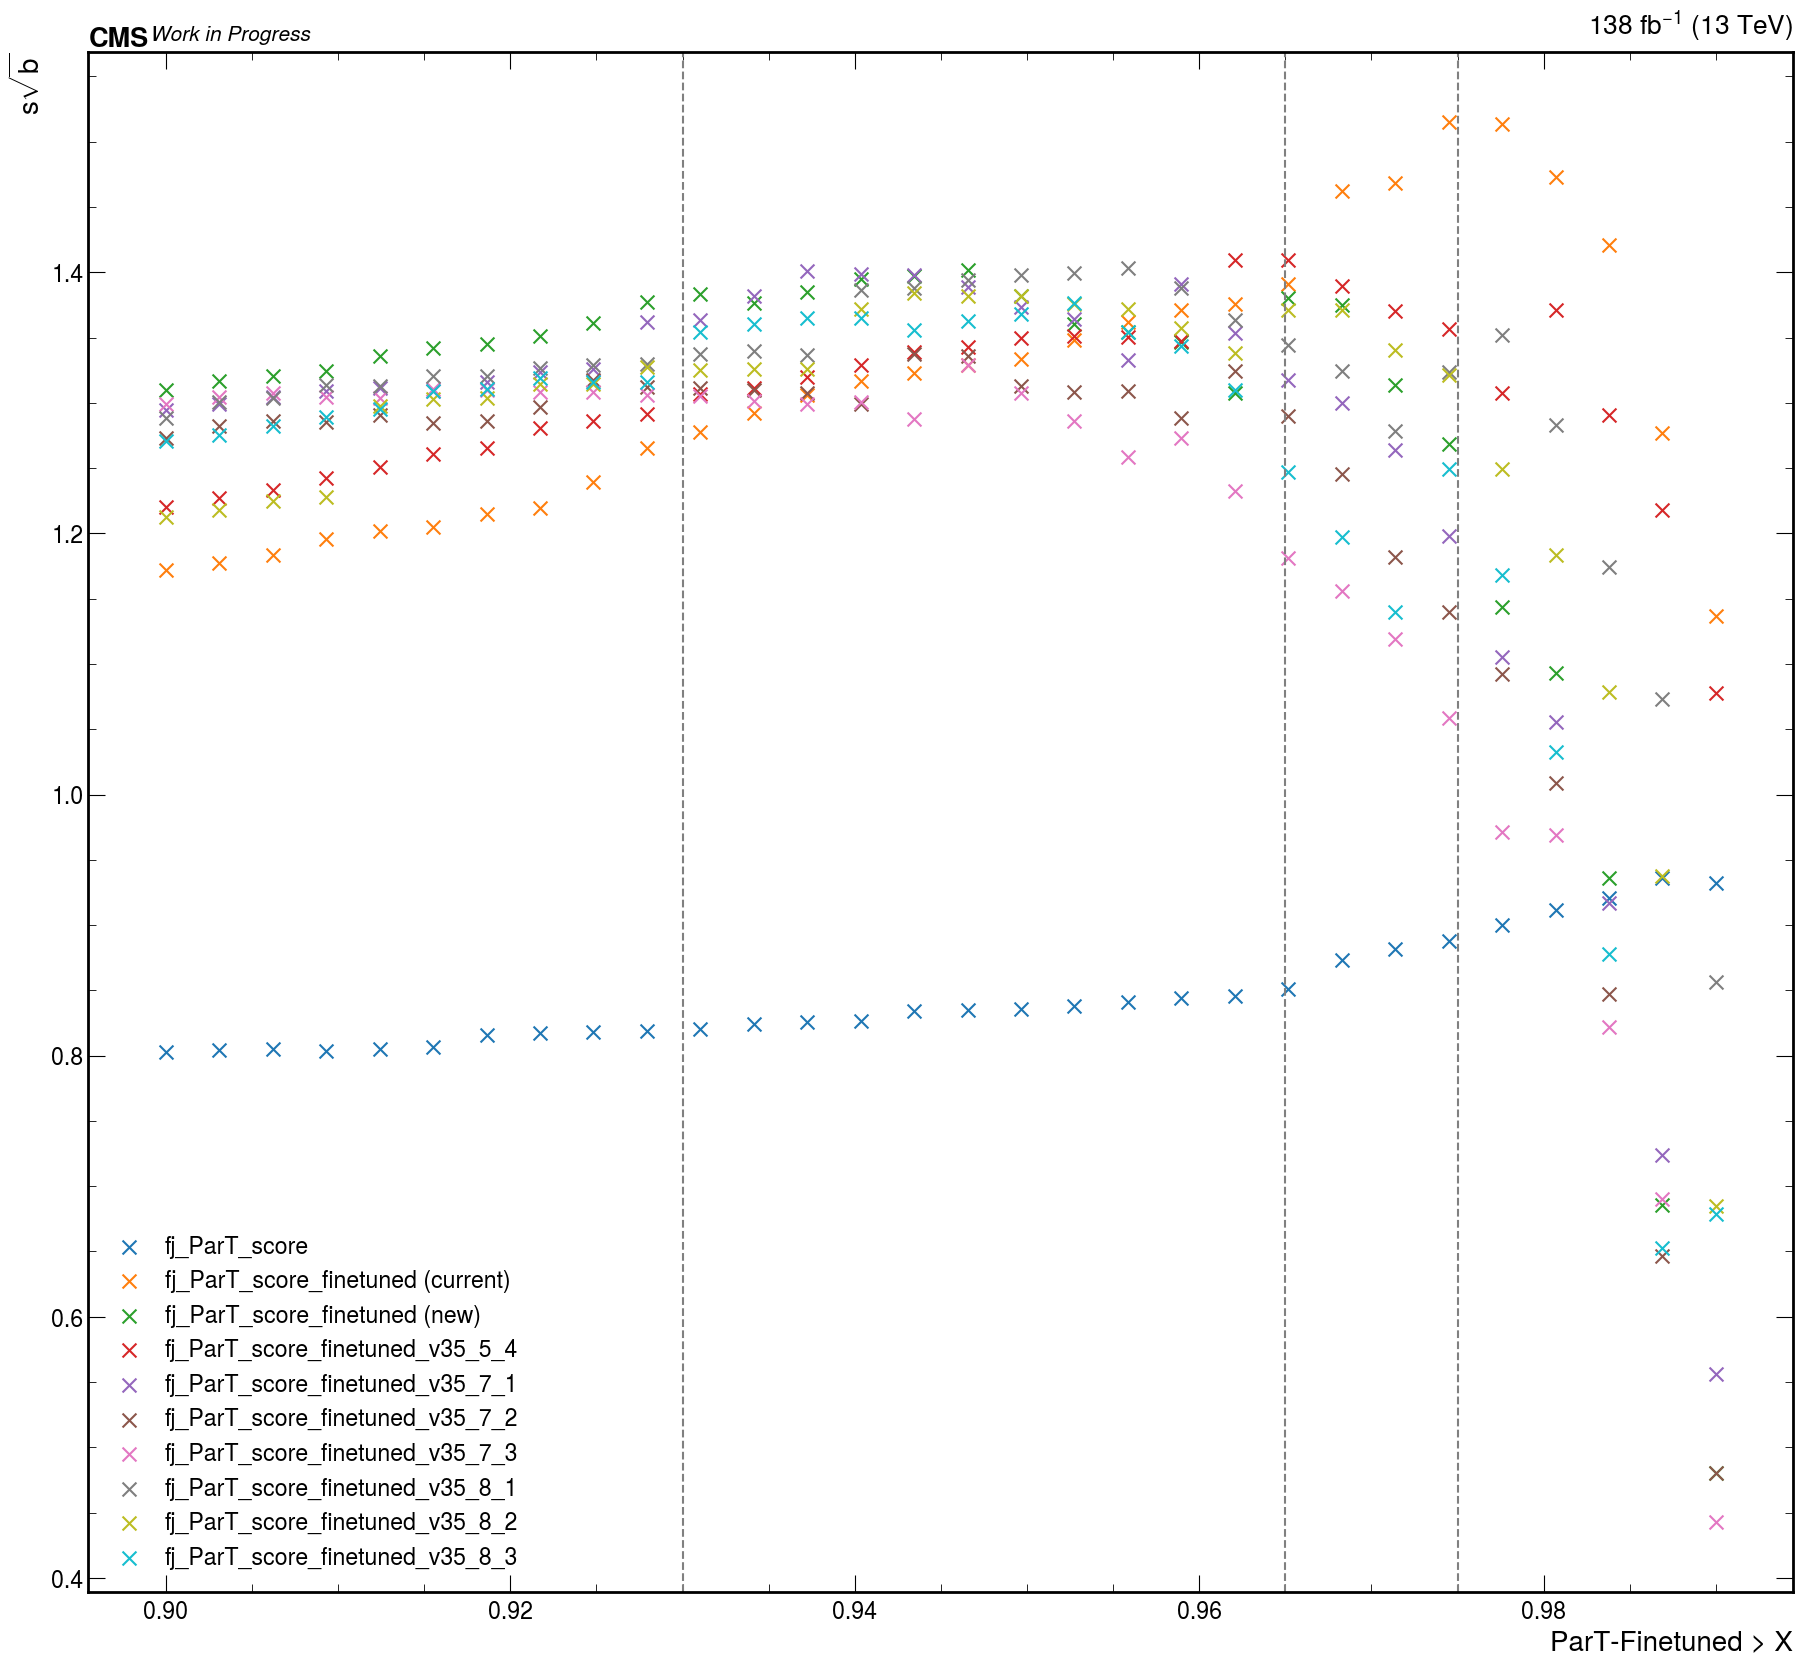

In [211]:
plt.rcParams.update({"font.size": 20})

channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(22, 20))

taggers_to_plot = [
    "fj_ParT_score",
    "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_v35_1",
    "fj_ParT_score_finetuned_v35_2_6",


    "fj_ParT_score_finetuned_v35_5_1",
    "fj_ParT_score_finetuned_v35_5_2",
    "fj_ParT_score_finetuned_v35_5_3",
]
taggers_to_plot = taggerss

for tagger in taggers_to_plot:   
    if tagger == "fj_ParT_score_finetuned":
        lab = "fj_ParT_score_finetuned (current)"
    elif tagger == "fj_ParT_score_finetuned_v35_2_6":
        lab = "fj_ParT_score_finetuned (new)"
    else:
        lab = tagger
    
    ax.scatter(tagger_cuts, s_over_b[tagger], marker="x", s=100, label=lab)

ax.legend(loc="lower left")
ax.set_ylabel(r"$s\sqrt{b}$")
ax.set_xlabel("ParT-Finetuned > X")

ax.axvline(0.975, linestyle="--", color="grey")
ax.axvline(0.93, linestyle="--", color="grey")
ax.axvline(0.965, linestyle="--", color="grey")

# ax.set_xticks(tagger_cuts)
hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/soverb-new.pdf")

In [172]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = 0

In [191]:
vars_to_plot = [
#     "fj_msoftdrop",        
#     "rec_W_lnu_m",
#     "fj_pt",
#     "lep_pt",
#     "lep_eta",
    
#     "lep_fj_dr",
#     "lep_met_mt",
#     "met_fj_dphi",
#     "met_pt",    
    
#     "btag_1a",
#     "0btag_1b",
#     "1pbtag_1b",
    
#     "0btagT_btagSF",
#     "1plusbtagT_btagSF"
    
#     "rec_higgs_etajet_m",
#     "fj_ParT_mass",
#     "fj_ParT_score_finetuned"
    
    "rec_higgs_m",    
    # AN
#     "FirstFatjet_pt",
#     "SecondFatjet_pt",
#     "fj_pt",
#     "lep_pt",
#     "NumFatjets",
#     "NumOtherJets",
#     "lep_fj_dr",
#     "met_pt",
#     "met_fj_dphi",
#     "lep_met_mt",    
#     "ht",
#     "fj_mass",
#     "rec_W_qq_m",
#     "rec_W_lnu_m",    
#     "fj_lsf3",
    
#     "lep_isolation",
#     "lep_isolation_ele",
#     "lep_isolation_ele_highpt",
#     "lep_isolation_ele_lowpt",
    
#     "lep_isolation_mu",
#     "lep_isolation_mu_highpt",
#     "lep_isolation_mu_lowpt",   
    
#     "lep_misolation",
#     "lep_misolation_highpt",
#     "lep_misolation_lowpt",    
]

samples_to_plot = [
    "ggF", 
    "VBF",
    "ttH",
    "WH",
    "ZH",    
#     "QCD",
#     "DYJets",
    "WJetsLNu",
    
#     "WJetsLNu_unmatched",
#     "WJetsLNu_matched",

#     "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "EWKvjets",
    "Data",
    
    "WZQQorDYJets"
]

In [192]:
# tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
tagger = "fj_ParT_score_finetuned_v35_5_4"

tagger_cut = 0.95
# tagger_cut = 0.9
presel = {
#     "Pre-selection": f"fj_pt>0",   # dummy
#     "SR": f"({tagger}>{tagger_cut}) & (n_bjets_T==0)",   # dummy
    
    "SR": f"{tagger}>0.965",
    
#     "Pre-selection": f"(fj_ParT_score_finetuned>0.95) & (fj_msoftdrop>10)",   # dummy    
    
#     "Pre-selection": f"met_pt>100 & ({tagger}<0.5) & n_bjets_T>0",   # dummy    
#     "Pre-selection": f"met_pt>100 & n_bjets_T>0",   # dummy    

#     "Pre-selection": f"met_pt>100 & n_bjets_L==0 & {tagger}>0.5 & {tagger}<0.97",   # dummy    
    
#     "Pre-selection": f"met_pt>20",

#     "SR": f"({tagger}>0.98) & (n_bjets_T==0)",    
    
#     "SR2": f"({tagger}>0.97) & ({tagger}<0.98) & (n_bjets_T==0)",
#     "WJets CR": f"({tagger}<0.97) & ({tagger}>0.50) & (n_bjets_T==0) & (met_pt>100)",
#     "Top CR": f"({tagger}>0.5) & (n_bjets_T>0)",
}

categories_sel = {
#     "VBF": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( (mjj>1000) & (deta>3.5) )",
#     rf"ggF": "(mjj<1000) | (deta<3.5)",
        
#     r"ggF pT [250, 300]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>250) & (fj_pt<300) )",
#     f"ggF pT [300, 450]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>300) & (fj_pt<450) )",
#     r"ggF pT [450, Inf]": f"( (fj_ParT_score_finetuned>{tagger_cut}) & (n_bjets_T==0) ) & ( ( (mjj<1000) | (deta<3.5) ) & (fj_pt>450) )",
}

channels = ["ele", "mu"]
# channels = ["ele"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2016APV"]

num, den = 0, 0
threshold = 0

# fill histograms
hists = {}

# ev = events_dict["new_correctionsNOTAGGER"]

ev = events_dict
# ev = events_dict["wjetsNLO"]

# ev = events_dict["new_correctionsNODPHI"]

MET_cut = False
import utilsAN

massbin = 10
for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
        )    
    elif var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(45, 210, massbin)), name="var", label=r"ParT regressed mass [GeV]", overflow=True)
        )              
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utilsAN.axis_dict[var],
#             hist2.axis.Regular(50, 0, 1, name="var", label=r"tagger", overflow=True)
            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]
                
#                 if sample == "DYJets":
#                     continue  
#                 if sample == "WJetsLNu":
#                     df = ev[year][ch][sample]
#                     df = pd.concat([df, ev[year][ch]["DYJets"]])
#                 else:
#                     df = ev[year][ch][sample]


#                 if "WJetsLNu" in sample:
#                     df = ev[year][ch]["WJetsLNu"]
                    
#                     if "unmatched" in sample:
#                         df = df[df["fj_V_isMatched"]!=1]
#                     else:
#                         df = df[df["fj_V_isMatched"]==1]
                
#                 else:
#                     df = ev[year][ch][sample]
        
                df = ev[year][ch][sample]
                
                df = df.query(sel)
                    
                if "MET>X" in region:
                    MET_cut = 100
                    df = df[df["met_pt"]>MET_cut]
                                
                if len(categories_sel)>=1:
                    category, category_sel = list(categories_sel.items())[0]
                    df = df.query(category_sel)
            
#                 if sample == "QCD":
#                     threshold = 30
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]
                
                
                if "lep_isolation_ele" in var:
                    if ch=="ele":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>120)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<120)]                            

                        x = df["lep_isolation"]
                    else:
                        continue
                        
                elif "lep_isolation_mu" in var:
                    if ch=="mu":
                        
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_isolation"]

                    else:
                        continue
                    
                elif "lep_misolation" in var:
                    if ch == "mu":
                        if "highpt" in var:
                            df = df[(df["lep_pt"]>55)]
                        elif "lowpt" in var:
                            df = df[(df["lep_pt"]<55)] 

                        x = df["lep_misolation"]
                        
                    else:
                        continue

                else:
                    x = df[var]
                    
#                 if var == "lep_eta":
#                     x = np.absolute(df[var])
                
#                 df = df[np.absolute(df["lep_eta"])<0.5]
#                 x = df[var]
                
                w = df["event_weight"]
                
#                 if sample != "Data":
# #                     w *= df["btag_1a"]
#                     w *= df["0btag_1b"]
# #                     w *= df["1pbtag_1b"]

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=w,
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1
    
for var in vars_to_plot:
    fix_neg_yields(hists[var])

Will plot rec_higgs_m histogram


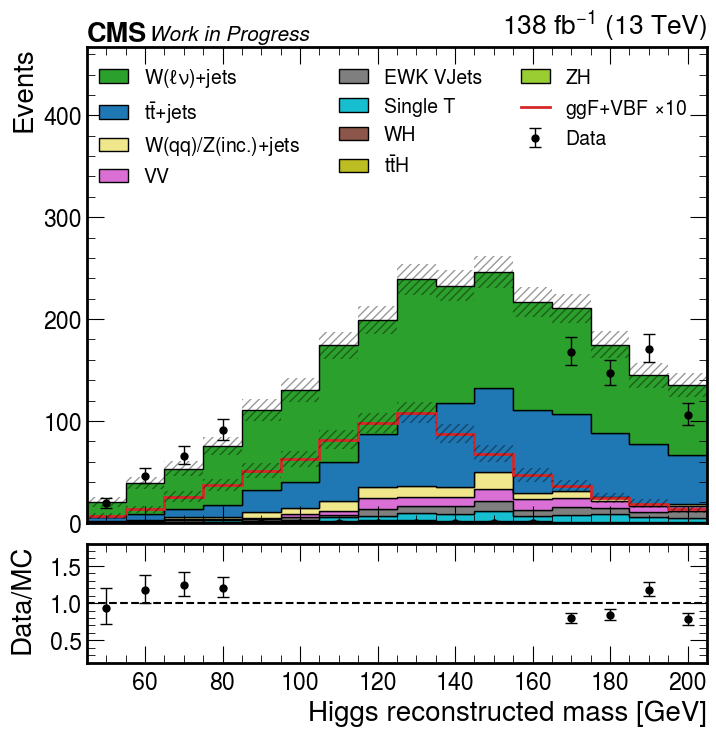

In [193]:
plt.rcParams.update({"font.size": 20})
add_data = True

if "SR" in region or ("Signal region") in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=10
    else:
        mult=10
else:
    add_soverb=True
    blind_region=[90,160]
    mult=10
    
    
from utils import plot_hists
if len(years) > 1:
    from utilsF import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_Run2/"
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/SignalRegion/"

#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_Run2/"
else:
    from utilsAN import plot_hists
    PATH = f"/Users/fmokhtar/Desktop/AN_2024/preselection_{years[0]}/"
#     PATH = f"/Users/fmokhtar/Desktop/AN_2024/sig_region_{list(categories_sel.keys())[0]}_{years[0]}/"

PATH = f"/Users/fmokhtar/Desktop/AN_2024/lol/"
# from utilsF import plot_hists

if not os.path.exists(PATH):
    # Create the directory
    os.makedirs(PATH)    

plot_hists(hists, years, channels, vars_to_plot,             
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=PATH,
            text_=region,
#             text_=region + f"\n {list(categories_sel.keys())[0]} category",
#             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
#             text_=region + f"\n Applying qcd event_weight<{threshold}",

            blind_region=blind_region,
#            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
          )
# print()
# get_soverb(ev, tagger, presel, categories_sel, years, channels, threshold=threshold, MET_cut=MET_cut)

In [62]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]
def get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=False, misocut=None, threshold=None):

    mass_window = [100, 150]

    num_sig = {
        "ggF": 0, 
#         "ttH": 0, 
#         "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "DYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    samples = [
        "ggF", 
        "VBF",
        "ttH",
        "WH",
        "ZH",        
        "QCD",
        "DYJets",
        "WJetsLNu",
        "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data"
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

                if MET_cut:
                    df = df[df["met_pt"]>MET_cut]
                    
                if threshold:
                    if sample == "QCD":
                        df = df[df["event_weight"] < threshold]
    
                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", list(categories_sel.keys())[0])

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

In [ ]:
fig, ax = plt.subplots(figsize=(9,8))

bins = np.linspace(45,210,20)

syst = "UES_down"


a = ax.hist(df["rec_higgs_m"], label="Nominal", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

d = ax.hist(df[f"rec_higgs_m{syst}"], label="down", weights=df["weight_ele"],
        bins=bins, lw=2, histtype="step", 
       )

# w = (df[f"rec_higgs_m{syst}"]/df["rec_higgs_m"])
# ax.hist(df[f"rec_higgs_m"], label="(should be down)", weights=df["weight_ele"] * w,
#         bins=bins, lw=1, histtype="step", 
#        )

ax.legend()
ax.set_xlabel("Higgs reconstructed mass [GeV]")
ax.set_ylabel("ggHWW events")
#         plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/JMSR/weight_{ch}_{syst}.pdf")